# LLM from scratch

The goal is to code from scratch (using Pytorch) a Transformer, more precisely a GPT-like model (using a decoder-only architecture).

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import trange

What we will do here: train a generative model with political speeches (State of the Union).
The goal is to generate more speeches!

In [5]:
# main model and data hyperparameters
batch_size = 32 # number of sequences processed in parallel
context_length = 64 # maximum context length for predictions
n_token = 512 # number of tokens (used for word level tokenizer)

# the rest of the hyper parameters are defined with the models
n_embed = 64 # size of hidden layer

Note: the hyper parameters were **not** optimised at all! Also, the code runs on CPU, not GPU. It is mostly for educational purposes.

## Part 1: Playing with the dataset

Let's download the dataset.

In [3]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/sotu.txt

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [6]:
with open('sotu.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = text.lower()
print(text[:1000])

mr. speaker, mr. president, and distinguished members of the house and senate,
honored guests, and fellow citizens: less than 3 weeks ago, i joined you on the
west front of this very building and, looking over the monuments to our proud
past, offered you my hand in filling the next page of american history with a
story of extended prosperity and continued peace. and tonight i'm back to offer
you my plans as well. the hand remains extended; the sleeves are rolled up;
america is waiting; and now we must produce. together, we can build a better
america.

it is comforting to return to this historic chamber. here, 22 years ago, i first
raised my hand to be sworn into public life. so, tonight i feel as if i'm
returning home to friends. and i intend, in the months and years to come, to
give you what friends deserve: frankness, respect, and my best judgment about
ways to improve america's future. in return, i ask for an honest commitment to
our common mission of progress. if we seize the oppor

In [7]:
data_size = len(text)
data_size

1279319

## Part 2: Word-level tokenizer

Instead of working at character level, we will now work at word level. The science of decomposing a text into tokens is a complicated one. Here we use `minbpe`, which implements the Byte Pair Encoding (BPE) algorithm commonly used in LLM tokenization.

In [8]:
from minbpe.minbpe import RegexTokenizer

The tokenizer takes a while to run so let's download a tokenizer (obtained using minbpe).

In [7]:
!wget https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.model
!wget https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.vocab

--2025-01-07 10:53:34--  https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2075 (2,0K) [text/plain]
Saving to: ‘tok512.model.1’

tok512.model.1      100%[===================>]   2,03K  --.-KB/s    in 0s      

2025-01-07 10:53:35 (13,5 MB/s) - ‘tok512.model.1’ saved [2075/2075]

--2025-01-07 10:53:35--  https://raw.githubusercontent.com/nathanael-fijalkow/llm_mva/main/tok512.vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7727 (7,5K) [text/plain]
Sa

In [9]:
tokenizer = RegexTokenizer()
tokenizer.load("tok512.model")

We encode the entire text dataset and store it into a `torch.Tensor`.

In [10]:
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

data.shape, data[:50]

(torch.Size([586714]),
 tensor([109, 114,  46, 276, 393, 384, 263,  44, 283, 114,  46, 274, 344, 340,
         300,  44, 279, 295, 383, 290, 117, 287, 258, 100, 283, 409,  98, 381,
         280, 262, 296, 301, 319, 279, 276, 270, 379, 461, 104, 264, 367, 100,
         312, 117, 101, 268, 115,  44, 279, 275]))

In [11]:
test = "hello world"
test_encoded = tokenizer.encode(test)
test_encoded, [tokenizer.decode([x]) for x in test_encoded], tokenizer.decode(test_encoded)

([258, 285, 111, 492], ['he', 'll', 'o', ' world'], 'hello world')

The longest tokens in political speeches according to BPE.

In [12]:
token_list = sorted([tokenizer.decode([x]) for x in range(n_token)], 
                    key=len, 
                    reverse=True)
token_list[:20]

[' America',
 'vernment',
 ' Americ',
 ' people',
 ' nation',
 'ongress',
 ' their',
 ' world',
 'ation',
 ' that',
 'meric',
 ' will',
 ' have',
 ' with',
 ' this',
 ' year',
 ' must',
 ' work',
 ' more',
 ' from']

## Part 3: Evaluating and training with batches

Our models will take as input `context_length` many tokens and produce the next token.

In [13]:
ix = torch.randint(len(data) - context_length, (1,))
sample = data[ix:ix+context_length+1]
sample_list = sample.tolist()
print("Input: ", sample_list[:-1], 
      "\nTarget: ", sample_list[-1])
print("\nHuman version:\nInput: ", tokenizer.decode(sample_list[:-1]), 
      "\nTarget: ", tokenizer.decode([sample_list[-1]]))

Input:  [440, 308, 110, 332, 306, 362, 273, 274, 344, 263, 297, 310, 256, 260, 309, 117, 344, 286, 307, 445, 508, 410, 357, 46, 279, 256, 264, 401, 461, 98, 101, 102, 367, 32, 105, 271, 108, 454, 44, 32, 105, 265, 431, 273, 286, 118, 272, 101, 307, 445, 273, 119, 110, 44, 307, 445, 271, 357, 44, 307, 445, 508, 410, 357] 
Target:  273

Human version:
Input:  ome.

now we have to preserve our treasures in every community. and tonight,
before i close, i want to invite every town, every city, every community 
Target:   to


In [14]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length - 1, (batch_size,))
    X = torch.stack([data[i:i+context_length] for i in ix])
    Y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return X, Y

X,Y = get_batch("train")
X.shape, Y.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

We illustrate below how the cross entropy loss is computed along batches (as the mean over the batches). The same works for most functions in Pytorch, which means that writing code for batches is almost as easy as without!

In [15]:
batch_size_test = 3
number_classes_test = 5

logits = torch.randn(batch_size_test, number_classes_test)
target = torch.randint(number_classes_test, (batch_size_test,), dtype=torch.int64)
loss = F.cross_entropy(logits, target)
print("logits: ", logits, "\ntarget: ", target, "\nloss: ", loss.item())

logits:  tensor([[ 1.8048, -1.6097,  0.0027,  0.4624, -0.5979],
        [-0.9204,  0.0782,  0.6094,  1.3502,  0.6142],
        [-1.9845, -1.4967,  1.4416, -0.5042,  0.0042]]) 
target:  tensor([0, 2, 0]) 
loss:  1.9457324743270874


Let us write again the boilerplate code for models, this time with batching.

In [16]:
@torch.no_grad()
def estimate_loss(model, eval_iters = 100):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

In [17]:
def train(model, n_iterations = 10000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(n_iterations):
        # every once in a while evaluate the loss on train and validation sets
        if iter % eval_interval == 0 or iter == n_iterations - 1:
            losses = estimate_loss(model, eval_iters)
            print(f"step {iter}: train loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")

        X,Y = get_batch("train")
        _, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

## Part 4: A Multi Layer Perceptron (MLP) model

We essentially implement the model from the paper "**A Neural Probabilistic Language Model**" by Bengio et al from 2003.

The first component is an `Embedding` layer: this is simply a lookup table, as illustrated below. It maps every token to a vector in fixed dimension. Since the dimension is much smaller than the number of tokens, intuitively the embedding layer will have to map similar tokens to similar vectors.

In [18]:
n_token_test = 3
n_embed_test = 4

embedding = torch.nn.Embedding(n_token_test, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)
print("Result of embedding token number 1:\n", embedding(torch.tensor([1])))

Weights of the embedding:
 Parameter containing:
tensor([[-1.6200, -1.3387, -1.0091, -0.6506],
        [-1.5841,  0.9753, -0.3023,  0.8927],
        [ 0.4028, -0.9253, -0.1636, -1.9022]], requires_grad=True)
Result of embedding token number 1:
 tensor([[-1.5841,  0.9753, -0.3023,  0.8927]], grad_fn=<EmbeddingBackward0>)


Let us describe how the model works. 

Recall that a datapoint is a tensor `x` of size `context_length`. Each of the `context_length` token is embedded, yielding a tensor of dimension `n_embed`. The resulting embeddings are concatenated to form a tensor of dimension `context_length * n_embed`, and then fed into a standard feed forward network. This is illustrated below (minus the network), with batches.

In [19]:
batch_size_test = 2
context_length_test = 3
n_token_test = 4
n_embed_test = 5

blank_token_test = n_token_test

idx = torch.randint(high = n_token_test, size = (batch_size_test, context_length_test))
print("Input tokens:\n", idx)
embedding = torch.nn.Embedding(n_token_test + 1, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)

print("*******************\n")

x = embedding(idx)
x.shape, x

Input tokens:
 tensor([[2, 1, 2],
        [1, 1, 0]])
Weights of the embedding:
 Parameter containing:
tensor([[-0.4856, -0.9944,  2.0843, -0.9169, -3.3437],
        [ 1.3260,  0.3148, -0.0123,  0.2897, -1.0599],
        [ 0.9793, -1.1672, -0.9390,  0.6150, -2.1677],
        [-0.7160, -0.0382,  0.0320, -1.3732, -0.7355],
        [-2.1030,  1.0515,  1.1116,  0.5956, -0.8307]], requires_grad=True)
*******************



(torch.Size([2, 3, 5]),
 tensor([[[ 0.9793, -1.1672, -0.9390,  0.6150, -2.1677],
          [ 1.3260,  0.3148, -0.0123,  0.2897, -1.0599],
          [ 0.9793, -1.1672, -0.9390,  0.6150, -2.1677]],
 
         [[ 1.3260,  0.3148, -0.0123,  0.2897, -1.0599],
          [ 1.3260,  0.3148, -0.0123,  0.2897, -1.0599],
          [-0.4856, -0.9944,  2.0843, -0.9169, -3.3437]]],
        grad_fn=<EmbeddingBackward0>))

In [20]:
class MLP(nn.Module):
    def __init__(self, n_embed2, n_embed = n_embed):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.net = nn.Sequential(
            nn.Linear(context_length * n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_token)
        )

    def forward(self, idx, y=None):
        B, T = idx.shape
        # if training: B = batch_size, otherwise B = 1
        # T = context_length

        x = self.token_embedding_table(idx).view(B, context_length * n_embed)
        # x.shape = (B, context_length * n_embed)
        
        logits = self.net(x) 
        # logits.shape = (B, n_token)
        
        if y is None:
            loss = None
        else:
            # B = batch_size
            # y.shape = (batch_size, context_length)
            logits = logits.view(batch_size, n_token)
            y = y[:,-1].view(batch_size)
            loss = F.cross_entropy(logits, y)

        return logits, loss 

In [21]:
model = MLP(n_embed2 = 4 * n_embed, n_embed = n_embed)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

1.213184  M parameters


In [22]:
tokenizer.encode("\n")[0]

10

In [23]:
def generate_MLP(model, max_new_tokens = 2000):
    idx = torch.ones((1, context_length), dtype=torch.long) * tokenizer.encode("\n")[0]
    for _ in range(max_new_tokens):
        # we crop at context_length
        idx_cond = idx[:, -context_length:]
        # forward pass
        logits, _ = model(idx_cond)
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).view((1,1))
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][context_length:].tolist())

The output is much better than before just because we use tokens, so independently words are more or less fine, but sentences are random.

In [24]:
print(generate_MLP(model, max_new_tokens = 50))

w�ake theyveowcist� to will]ud&�verWery��&�P2art' N�ace�ost�ie pee�� pro d%ge#ace'_ fromiv*


In [22]:
train(model, n_iterations = 10000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

step 0: train loss 6.2794, validation loss 6.2661
step 1000: train loss 4.7952, validation loss 4.9670
step 2000: train loss 4.4097, validation loss 4.6843
step 3000: train loss 4.1519, validation loss 4.5002
step 4000: train loss 4.0441, validation loss 4.4726
step 5000: train loss 3.9435, validation loss 4.3045
step 6000: train loss 3.8582, validation loss 4.3186
step 7000: train loss 3.8481, validation loss 4.2805
step 8000: train loss 3.7634, validation loss 4.2957
step 9000: train loss 3.7942, validation loss 4.2351
step 9999: train loss 3.7086, validation loss 4.2035


In [23]:
print(generate_MLP(model, max_new_tokens = 200))

ps mi th in b its  rec-t this to uned mas our e pens t
sts
e tose sop the med,. we we wed st are of a cieves that can sembe. mient goods of our congress of our,
wth. whict. leed us ad working resourbwe ditar the stasecd am
botge firs rvation.

bititive. the firunal startst actes of fouility that butive s/b
for
ourrerests--mass sicon these din. talarsofye startardots, rd for hastd
mostks, we have not go agistment pur


## Part 6: Attention mechanism

### A self-attention head

Attention is a **communication mechanism**. In our case, the tokens communicate information and determine which tokens are relevant for them.

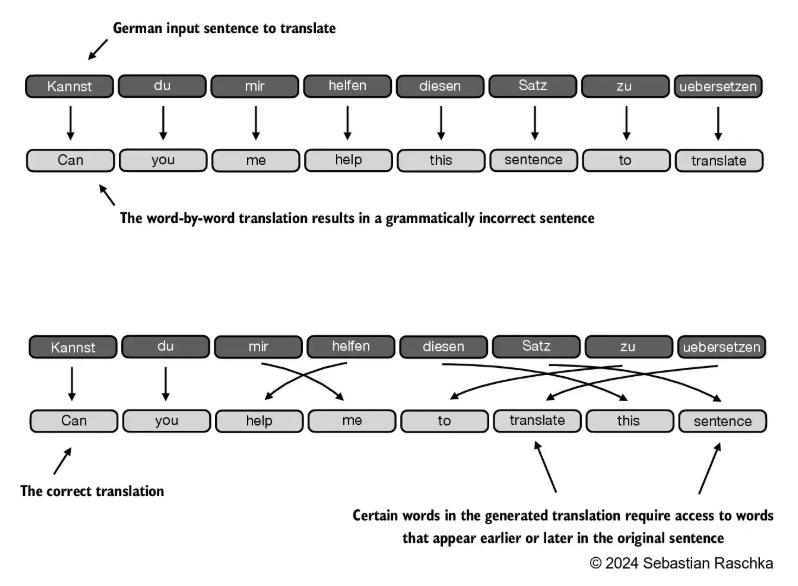

The input of the head is for each token a tensor of dimension `head_input_dim`, forming a tensor `x: (context_length,head_input_dim)`.
The goal is to compute for each token a context tensor, so a tensor `z: (context_length,head_output_dim)`. The context tensor for token `i` will be a weighted average of all input tensors multiplied by their attention weights. More precisely, for computing the context tensor for token `i`, we compute the attention of `i` with each token `j`, and multiply the input of `j` by the attentin of `i` for `j`.

### Shall we?

In [25]:
class Head(nn.Module):
    def __init__(self, head_input_dim, head_size, head_output_dim):
        super().__init__()
        self.key = nn.Linear(head_input_dim, head_size, bias=False)
        self.query = nn.Linear(head_input_dim, head_size, bias=False)
        self.value = nn.Linear(head_input_dim, head_output_dim, bias=False)
        # Some Pytorch way of defining a matrix without trainable parameters 
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))     
        
        self.head_size = head_size

    def forward(self, x):
        B, T, C = x.shape
        # if training: B = batch_size, else B = 1
        # T = context_length
        # I = head_input_dim
        # H = head_size
        # O = head_output_dim
        
        k = self.key(x)   # (B, T, H)
        q = self.query(x) # (B, T, H)
        v = self.value(x) # (B, T, O)
        attention_scores = q @ k.transpose(1,2) # (B, T, H) @ (B, H, T) -> (B, T, T)
        mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
        masked_attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        attention_weights = torch.softmax(masked_attention_scores * self.head_size**-0.5, dim=-1) # (B, T, T)
        context_vectors = attention_weights @ v # (B, T, T) @ (B, T, O) -> (B, T, O)
        return context_vectors

**Positional encoding**: There is no notion of space, the attention mechanism acts over a **set** of vectors. This is why we need to positionally encode tokens. Two solutions:
* Learning an embedding of positions
* Using a fixed embedding

Here we use the first solution but illustrate the second one below.

Suppose that the input representation $X \in \mathbb{R}^{n \times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. 
The positional encoding outputs $X + P$ using a positional embedding matrix $P$ of the same shape, whose element on the $i$-th row and the $2j$-th or the $2j+1$-th column is
$$P(i,2j) = \text{sin}\left( \frac{i}{10000^{2j / d}} \right)$$
$$P(i,2j+1) = \text{cos}\left( \frac{i}{10000^{2j / d}} \right)$$

Credit for the code and picture: Jonathan Kernes, https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3

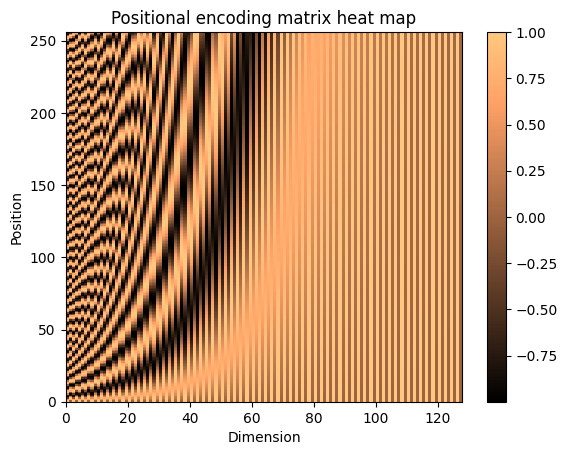

In [26]:
import numpy as np
import matplotlib.pyplot as plt
def positional_encoding(max_position, model_dim, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(model_dim)//2)/model_dim)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc
    
model_dim = 128
max_pos = 256
mat = positional_encoding(max_pos, model_dim)
plt.pcolormesh(mat, cmap='copper')
plt.xlabel('Dimension')
plt.xlim((0, model_dim))
plt.ylabel('Position')
plt.title("Positional encoding matrix heat map")
plt.colorbar()
plt.show()

This model is just an illustration of what can be done with a single head plus positional encoding.

In [27]:
class SingleHeadPositional(nn.Module):
    
    def __init__(self, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.self_attention_head = Head(head_input_dim = n_embed, 
                                        head_size = head_size, 
                                        head_output_dim = head_output_dim)
        self.last_head = nn.Linear(head_output_dim, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # T = context_length
        
        # I = head_input_dim = n_embed
        # H = head_size
        # O = head_output_dim

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_head(x) # (B, T, H)
        logits = self.last_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [28]:
def generate(model, max_new_tokens = 2000):
    idx = torch.ones((1, context_length), dtype=torch.long) * tokenizer.encode("\n")[0]
    for _ in range(max_new_tokens):
        # we crop at context_length
        idx_cond = idx[:, -context_length:]
        # forward pass
        logits, _ = model(idx_cond)
        # use the logits for the full context
        logits = logits[:,-1,:]
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).view((1,1))
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][context_length:].tolist())

In [29]:
model = SingleHeadPositional(head_size = 16, head_output_dim = n_embed)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

0.076288  M parameters


In [30]:
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

step 0: train loss 6.2627, validation loss 6.2612
step 1000: train loss 4.0374, validation loss 4.1527
step 2000: train loss 3.7672, validation loss 3.9077
step 3000: train loss 3.6989, validation loss 3.8471
step 4000: train loss 3.6643, validation loss 3.8026
step 5000: train loss 3.6290, validation loss 3.7932
step 6000: train loss 3.6151, validation loss 3.7705
step 7000: train loss 3.6072, validation loss 3.7721
step 8000: train loss 3.5922, validation loss 3.7671
step 9000: train loss 3.5773, validation loss 3.7545
step 10000: train loss 3.5708, validation loss 3.7328
step 11000: train loss 3.5590, validation loss 3.7317
step 12000: train loss 3.5555, validation loss 3.7263
step 13000: train loss 3.5464, validation loss 3.7260
step 14000: train loss 3.5477, validation loss 3.7321
step 15000: train loss 3.5376, validation loss 3.7081
step 16000: train loss 3.5280, validation loss 3.7068
step 17000: train loss 3.5238, validation loss 3.7046
step 18000: train loss 3.5168, validation

In [31]:
print(generate(model, max_new_tokens = 200))

bund to just gwth hopfiate to gear inter teest per ident ign and prection affor threates a hous respeople ago,
in-er to arime has ham acy difere should dons withinate the year crority.

ike to crepow, tooin this care in the ed on
ildrenarget ins fedic
to lead.

lements have mance speaking baliburity ripan work in ider the futionalizened n cutive to
ack otheir toget that american ev,
then
theners areas
inubilitizens gar from is als beh in l


### From single head to multi headed attention

In [32]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_head, head_size, head_output_dim):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_input_dim = n_embed, 
                                         head_size = head_size, 
                                         head_output_dim = head_output_dim) for _ in range(n_head)])
        self.proj = nn.Linear(n_head * head_output_dim, n_embed)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

We enrich the previous model with parallel heads, called multi head.

In [33]:
class MultiHeadPositional(nn.Module):
    
    def __init__(self, n_head, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                      head_size = head_size,
                                                      head_output_dim = head_output_dim) 
        self.last_head = nn.Linear(n_embed, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = context_length
        # I = head_input_dim 
        
        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_heads(x) # (B, T, n_embed)
        logits = self.last_head(x) # (B, T, n_token)
        
        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [34]:
model = MultiHeadPositional(n_head = 6, 
                            head_size = 16,
                           head_output_dim = 16)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)
print(generate(model, max_new_tokens = 200))

0.094784  M parameters
step 0: train loss 6.2372, validation loss 6.2373
step 1000: train loss 4.0505, validation loss 4.1404
step 2000: train loss 3.8227, validation loss 3.9610
step 3000: train loss 3.6732, validation loss 3.8190
step 4000: train loss 3.5429, validation loss 3.7107
step 5000: train loss 3.3900, validation loss 3.5731
step 6000: train loss 3.2986, validation loss 3.5090
step 7000: train loss 3.2300, validation loss 3.4367
step 8000: train loss 3.1610, validation loss 3.3915
step 9000: train loss 3.1090, validation loss 3.3561
step 10000: train loss 3.0614, validation loss 3.3334
step 11000: train loss 3.0339, validation loss 3.3161
step 12000: train loss 2.9970, validation loss 3.2925
step 13000: train loss 2.9898, validation loss 3.2673
step 14000: train loss 2.9558, validation loss 3.2505
step 15000: train loss 2.9397, validation loss 3.2412
step 16000: train loss 2.9222, validation loss 3.2313
step 17000: train loss 2.9111, validation loss 3.2336
step 18000: train 

## Some deep learning magic to make training easier

### Normalization layers

In [35]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [36]:
module = LayerNorm(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

We compute the mean and standard deviation of one (the first) feature across all batch inputs:

In [37]:
x[:,0].mean(), x[:,0].std()
# NOT normalised

(tensor(0.0876), tensor(0.8430))

Now, the mean and standard deviation of the features for a single input from the batch:

In [38]:
x[0,:].mean(), x[0,:].std()
# normalised

(tensor(4.7684e-09), tensor(1.0000))

### Sequential blocks

In [39]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed2, n_embed = n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed2),
            nn.Tanh(),
            nn.Linear(n_embed2, n_embed),
        )

    def forward(self, x):
        return self.net(x)

In [40]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_head, head_size, head_output_dim, n_embed2):
        super().__init__()
        self.self_attention_heads = MultiHeadAttention(n_head = n_head,
                                                       head_size = head_size,
                                                       head_output_dim = head_output_dim)
        self.ffwd = FeedFoward(n_embed2 = n_embed2, n_embed = n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # here are skip connections, also called residual connections
        # they help training deep neural networks by adding a pathway to the input
        x = x + self.self_attention_heads(x)

        # normalization layer; recent implementations put them before self attention heads!
        x = self.ln1(x)
        
        # and again skip connections:
        x = x + self.ffwd(x)

        # and again normalization layer
        x = self.ln2(x)

        return x

This is the full model, almost as in the **Attention is all you need** paper (see below for differences).

In [41]:
class LanguageModel(nn.Module):

    def __init__(self, n_head, head_size, head_output_dim, n_embed2, n_layer):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.blocks = nn.Sequential(*[Block(n_head, head_size, head_output_dim, n_embed2) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, n_token)

    def forward(self, idx, y=None):
        B, T = idx.shape
        # I = head_input_dim = head_output_dim = n_embed

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)
        x = self.blocks(x) # (B, T, I)
        x = self.ln_f(x) # (B, T, I)
        logits = self.lm_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            B, T, _ = logits.shape
            logits = logits.view(B*T, n_token)
            y = y.view(B*T)
            loss = F.cross_entropy(logits, y)

        return logits, loss

In [42]:
model = LanguageModel(n_head = 6, 
                      head_size = 16,
                      head_output_dim = 16,
                      n_embed2 = 4 * n_embed,
                      n_layer = 4)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
train(model, n_iterations = 20000, learning_rate = 1e-3, eval_interval = 1000, eval_iters = 100)

0.302208  M parameters
step 0: train loss 6.3976, validation loss 6.3980
step 1000: train loss 3.4030, validation loss 3.6014
step 2000: train loss 2.9705, validation loss 3.2597
step 3000: train loss 2.8173, validation loss 3.1416
step 4000: train loss 2.6992, validation loss 3.0714
step 5000: train loss 2.6397, validation loss 3.0307
step 6000: train loss 2.5973, validation loss 2.9987
step 7000: train loss 2.5511, validation loss 2.9845
step 8000: train loss 2.5184, validation loss 2.9620
step 9000: train loss 2.5008, validation loss 2.9369
step 10000: train loss 2.4788, validation loss 2.9394
step 11000: train loss 2.4441, validation loss 2.9319
step 12000: train loss 2.4432, validation loss 2.9362
step 13000: train loss 2.4213, validation loss 2.9243
step 14000: train loss 2.4118, validation loss 2.9068
step 15000: train loss 2.4083, validation loss 2.9338
step 16000: train loss 2.3857, validation loss 2.9221
step 17000: train loss 2.3743, validation loss 2.9051
step 18000: train 

In [43]:
print(generate(model, max_new_tokens = 500))

buba way to road, marned communate in our schools it way foot on common hy
the tasks for the help of soviet government's donest, a good stimitars in education,
train to
make more, administration is not aly asoptively to discreters al me.

today desert, doubt european 38 years ago as entern
the 21st century men. there are really that be enact, since; violent role will
make one more to have the sacrifice of east certain decision which implemented by politics, the
continental action on separate basempts of solale. by impen civil congressional
from every act towe non to a non use thing that issues we think head work.

this medicare, we changed on human right $955,600, 63 with five convene
solating.

gaps not with cout fully benefits, the world potent on a 15
finding its legars, arzlon-dollar slavery that corporate grees
mortgages such our fellow in the world. i want a reductive a lot to look
salents to go to provide a century--we cal migned, and family, reserve
great seconducts on the fver

Machine translation requires an encoder-decoder architecture:
* the encoder encodes the input, using the exact same code as above, except that self attention is not masked (all tokens communicate with each other). To get an "encoder" attention block we just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
* the decoder is still auto-regressive, meaning it's conditioned on what's already been generated, but also on the result of the encoder. More specifically, the keys and values in each attention layer are coming from the encoder itself. The term "self-attention" means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module).

ChatGPT (or prompting) requires a fine-tuning phase (we covered only pre-training) where the network aligns with prompts and expected answers. It's based on reinforcement learning and a reward model for correct answers to prompts.

The full Transformer architecture (credits: original paper, Attention is all you need)

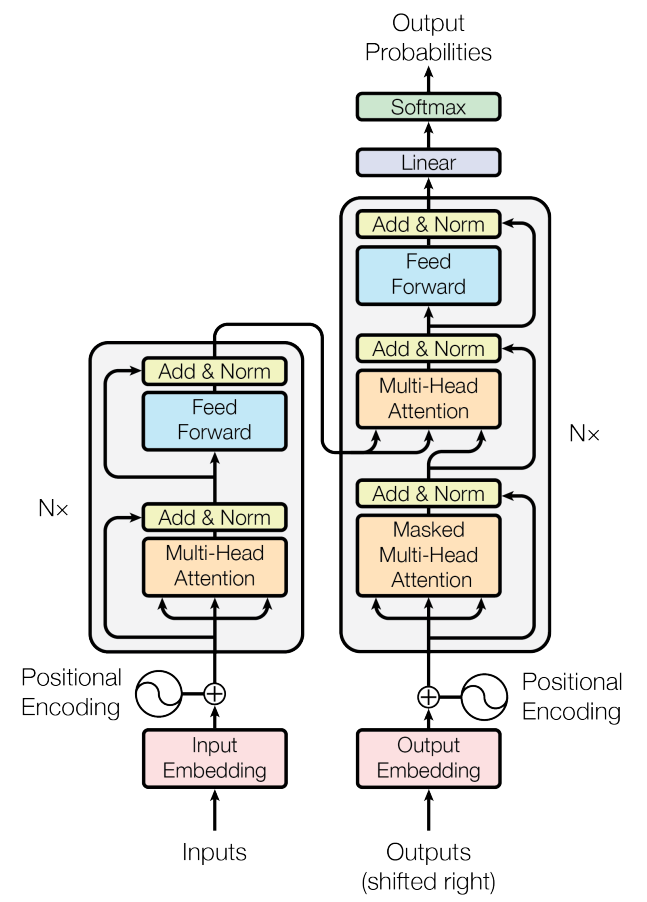

Next steps? Read this code: https://github.com/karpathy/minGPT/ and this one: https://github.com/karpathy/nanoGPT
They have a lot more teeth than the current one.